In [1]:
!pip install -r requirements.txt

In [2]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import Categorical
from torch.optim import Adam
from collections import deque  # use deque to store last few frames

/usr/local/lib/python3.7/dist-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


In [3]:
env = gym.make("CartPole-v0")
actions = [0, 1]
# create a sequence using last l frames
# pre-process sequence into a tensor for feed-forward
# for CartPole-v0, single frame has enough info, so l = 1
l = 1
lr = 5e-4  # learning rate
gamma = 0.9  # discount factor
eps = 0.1  # epsilon in clip function
beta = 0.001  # coeff for entropy loss
iterations = 500
N = 20  # rollouts per iteration
epochs = 5  # epochs per iteration
normalize = True  # normalize returns b/w 0 and 1
mod = 20  # print and save model once every mod iterations

In [4]:
# Actor is the policy network
class Actor(nn.Module):
  def __init__(self):
    super(Actor, self).__init__()
    self.fc = nn.Linear(4, 128)
    self.out = nn.Linear(128, len(actions))

  def forward(self, x):
    x = F.relu(self.fc(x))
    x = F.softmax(self.out(x), -1)
    return x


# Critic is the value network
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.fc = nn.Linear(4, 128)
    self.out = nn.Linear(128, len(actions))

  def forward(self, x):
    x = F.relu(self.fc(x))
    x = self.out(x)
    return x


# pre-process frame sequence
def phi(seq):
  return np.array(seq)

In [5]:
device = torch.device("cuda")

# initialize neural nets
pi = Actor().to(device)
pi_old = Actor().to(device)
Q = Critic().to(device)

# use single optimizer for both networks
opt = Adam(list(pi.parameters()) + list(Q.parameters()), lr)

![](https://miro.medium.com/max/1838/0*9KP9fMyqHfQs2tD3)

In [6]:
def sample(logits):
  # pick action from prob distribution logits
  return logits.sample().item()


# rs is array of rewards
# need array of returns Gs
# where Gs[t] is return after timestep t
def accumulate(rs):
  Gs = np.array([r for r in rs])
  for t in range(len(Gs) - 2, -1, -1):
    Gs[t] += gamma * Gs[t + 1]
  return torch.tensor(Gs, dtype=torch.float32, device=device)


def compute_loss(S, a, Gs, oldps):
  if normalize:
    Gs = (Gs - Gs.mean()) / (Gs.std() + 1e-5)  # normalize returns if needed
  # get Q(s, a) values
  Qs = torch.gather(Q(S), 1, a).squeeze()
  # get probabilities pi(a|s)
  ps = torch.gather(pi(S), 1, a).squeeze()
  ratio = ps / oldps  # compute prob ratio pi(a|s) / pi_old(a|s)
  A = (Qs - Gs).detach()  # compute advantage
  obj = ratio * A  # compute r(theta) * A (as per pseudocode)
  # compute clipped objective
  obj_clip = torch.clip(ratio, 1 - eps, 1 + eps) * A
  # compute surrogate objective = mean of minimum of above two objectives
  # -ve because we're doing gradient ascent
  surr_obj = -torch.minimum(obj, obj_clip).mean()
  # compute the entropy loss - acts as regularizer for policy network
  entropy_loss = beta * (-ps * torch.log(ps)).mean()
  actor_loss = surr_obj - entropy_loss  # loss for policy network
  critic_loss = F.mse_loss(Qs, Gs)  # loss for critic network
  return actor_loss + critic_loss  # loss for both networks


# avg loss over N episodes (or rollouts)
def avg_loss(rollouts):
  loss = 0
  for (S, a, Gs, oldps, _) in rollouts:
    loss += compute_loss(S, a, Gs, oldps) / N
  return loss


# avg return over N episodes
def avg_return(rollouts):
  return sum(G for (_, _, _, _, G) in rollouts) / N
 

def rollout():
  # states, action ids, rewards, and probabilities
  S, a, rs, oldps = [], [], [], []
  G = 0  # store return
  done = False
  s = env.reset()
  # create intial sequence of last l frames
  seq = deque([np.zeros_like(s)] * (l - 1) + [s], maxlen=l)
  with torch.no_grad():
    while not done:
      # pre-process last l frames, i.e., sequence seq
      s = torch.tensor(phi(seq), dtype=torch.float32, device=device)
      S.append(s.squeeze(0))  # store pre-processed state
      p = pi_old(s).squeeze()  # compute probability distribution
      i = sample(Categorical(p))  # pick action
      a.append([i])  # store action
      oldps.append(p[i])  # store probability of taking action
      s, r, done, _ = env.step(actions[i])  # take action
      G += r
      rs.append(r)  # store reward
      # append new state to sequence so it contains last l frames
      # sequence contained states [s_{t - l} ... s_t]
      # now contains [s_{t - l + 1} ... s_{t + 1}]
      seq.append(s)
  Gs = accumulate(rs)  # compute returns
  # convert list of states and probs to tensors for training
  S, oldps = torch.stack(S), torch.stack(oldps)
  # need to pick pi(a|s) during training, need 'a' as tensor to use torch.gather
  a = torch.tensor(np.array(a), device=device)
  return S, a, Gs, oldps, G


def train():
  returns = []
  for n in range(1, iterations + 1):
    # pi_old := pi
    pi_old.load_state_dict(pi.state_dict())
    # generate N rollouts
    rollouts = [rollout() for _ in range(N)]
    # store avg return of N rollouts
    returns.append(avg_return(rollouts))
    # train pi
    for _ in range(epochs):
      opt.zero_grad()
      loss = avg_loss(rollouts)
      loss.backward()
      opt.step()
    # log results once every mod iterations
    if n % mod == 0:
      print("episode: {}\tavg return: {:.2f}".format(n * N, returns[-1]))
  return returns

In [7]:
returns = train()
torch.save(pi_old.state_dict(), f"pi.pt")

episode: 400	avg return: 23.85
episode: 800	avg return: 21.90
episode: 1200	avg return: 19.40
episode: 1600	avg return: 17.90
episode: 2000	avg return: 25.70
episode: 2400	avg return: 31.45
episode: 2800	avg return: 35.50
episode: 3200	avg return: 44.85
episode: 3600	avg return: 49.25
episode: 4000	avg return: 47.45
episode: 4400	avg return: 46.70
episode: 4800	avg return: 53.45
episode: 5200	avg return: 49.65
episode: 5600	avg return: 41.55
episode: 6000	avg return: 40.65
episode: 6400	avg return: 41.75
episode: 6800	avg return: 44.50
episode: 7200	avg return: 52.00
episode: 7600	avg return: 34.20
episode: 8000	avg return: 38.65
episode: 8400	avg return: 41.65
episode: 8800	avg return: 36.40
episode: 9200	avg return: 33.65
episode: 9600	avg return: 41.80
episode: 10000	avg return: 40.70


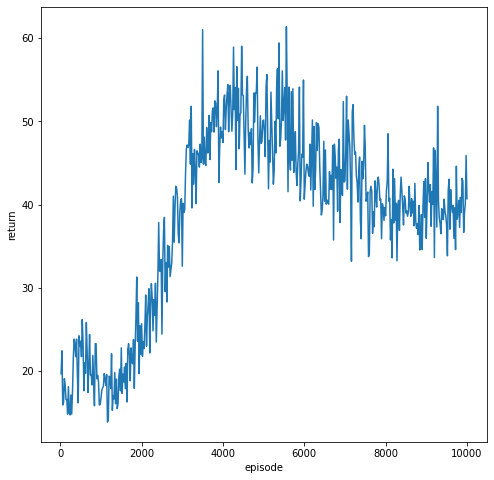

In [8]:
fig = plt.figure(figsize=(8, 8))
x = np.arange(1, iterations + 1) * N
plt.xlabel("episode")
plt.ylabel("return")
plt.plot(x, returns)
plt.savefig("returns.png")